Dans le texte qui suit nous allons continuer à interpréter les données provenant de la compétition "Ghoul, Ghost and Goblin" organisée par le site internet kaggle.com durant le mois d'octobre 2016. Cette compétition avait pour but de classer correctement un jeu de données dans trois catégories "Ghoul", "Ghost" ou "Goblin" et la métrique utilisée pour déterminer la note de chaque participant était le taux d'exactitude des données classées, soit le nombre de classifications juste divisé par le nombre total d'observations dans le jeu de données.

Dans la section précédente, j'ai décrit les données et expliqué la démarche que j'ai suivie lors de l'exploration des données à classer. Maintenant, nous sommes à l'étape de la modélisation des données. Commençons par enregistrer les données de la compétition dans les data table monstres et monstres_test, contenant les données servant à entraîner nos algorithmes et à valider le modèle, respectivement. (Note: je vais passé rapidement sur ces étapes puisque je j'ai déjà expliqué ces étapes dans la section précédente accessible à l'adresse https://github.com/GTouzin/Portfolio/blob/master/R/Kaggle_GGG_exploration.ipynb) 

In [2]:
# Charger les packages à utiliser
library(data.table)
library(ggplot2)
library(ggthemes)
library(corrplot)


#Lire les données 
monstres <- fread("./Kaggle/train/train.csv",stringsAsFactors = T)
monstres_test <- fread("./Kaggle/test/test.csv",stringsAsFactors = T)
head(monstres)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
1,0,0.3545122,0.350839,0.4657609,0.7811417,clear,Ghoul
2,1,0.5755599,0.4258684,0.5314014,0.4398989,green,Goblin
3,2,0.4678755,0.3543304,0.8116161,0.791225,black,Ghoul
4,4,0.7766525,0.5087225,0.6367656,0.8844637,black,Ghoul
5,5,0.5661166,0.8758618,0.4185937,0.6364378,green,Ghost
6,7,0.4056797,0.2532775,0.4414197,0.2803238,green,Goblin


Ensuite, j'ai créé deux échantillons aléatoires: train contenant les données que j'ai utilisées pour entraîner les différents algorithmes et cross_val contenant le reste des données qui serviront lors de la validation croisée.

In [100]:
set.seed(97)
train.indice <- sample(1:nrow(monstres), round(nrow(monstres)*0.7))
train <- monstres[train.indice , ]
cross_val <- monstres[-train.indice , ]

Finalement, j'ajoute aux data table des colonnes contenant les nouvelles variables que j'ai crues bon créer durant l'exploration des données.

In [101]:
train$soul_square=train$has_soul*train$has_soul
train$hair_square=train$hair_length*train$hair_length
train$bone_square=train$bone_length*train$bone_length

train$hair_time_soul=train$hair_length*train$has_soul
train$hair_time_bone=train$hair_length*train$bone_length
train$bone_time_soul=train$bone_length*train$has_soul

train$color<-as.factor(train$color)
train$type<-as.factor(train$type)

In [102]:
cross_val$hair_square=cross_val$hair_length*cross_val$hair_length
cross_val$soul_square=cross_val$has_soul*cross_val$has_soul
cross_val$bone_square=cross_val$bone_length*cross_val$bone_length

cross_val$hair_time_soul=cross_val$hair_length*cross_val$has_soul
cross_val$hair_time_bone=cross_val$hair_length*cross_val$bone_length
cross_val$bone_time_soul=cross_val$bone_length*cross_val$has_soul    

cross_val$color <- factor(cross_val$color)
cross_val$type <- factor(cross_val$type)

# Modèle de base : K-means 


Avant de tester l'efficacité des nouvelles variables, nous allons créer un modèle contenant toutes les variables initiales et estimer l'efficacité du modèle. Cela va nous permettre d'avoir une valeur de référence pour vérifier si on fait de bons choix lors de l'élaboration du modèle.

J'ai choisi d'utiliser l'algorithme "K-means", K-moyennes en français, pour créer le premier modèle, car ce dernier a pour avantage d'être rapide, simple et n'utilise pas beaucoup de mémoire. Donc, cet algorithme est idéal pour tester des hypothèses. De plus, cette méthode fait partie d'une classe d'algorithmes d'ont l'efficacité dépend grandement de la séparation des données provenant des trois catégories. Donc si l'algorithme "K-means" est peu efficace, nous pourrons conclure que ces autres algorithmes seront à éviter pour modéliser ces données qui ne sont pas linéairement séparables.    

Commençons par transformer les valeurs de la variable catégorique "color" en valeur numérique normalisées.

In [6]:
library(plyr)
train$color<-revalue(train$color, c("black"=0, "blood"=1/5, "blue"=2*1/5, "clear"=3*1/5, "green"=4*1/5, "white"=1))
levels(train$color)

[1] "0"   "0.2" "0.4" "0.6" "0.8" "1"

In [55]:
set.seed(97)
vars <- names(train) %in% c("bone_length", "rotting_flesh", "hair_length","has_soul","color")
model.kmeans.base <- kmeans(subset(train, select=vars), 3, nstart = 75)

Examinons la justesse du modèle en créant un tableau de contingence où les lignes contiennent les effectifs des grappes de points générés par l'algorithme et où les colonnes contiennent les véritables effectifs de chacune des trois catégories. 

In [69]:
table<-table(model.kmeans.base$cluster, train$type)
table

   
    Ghost Ghoul Goblin
  1    20    42     37
  2    13    16      9
  3    44    43     36

L'algorithme génère des grappes de points sans tenir compte des catégories des observations. En conséquence, pour calculer la précision du modèle, nous devons catégoriser chacune des grappes. Pour ce faire, j'ai associé chaque catégorie avec la grappe qui contient le plus grand nombre d'observations de cette catégorie. Donc la grappe 1 est associée à la catégorie "Ghoul", la grappe 2 est associée à "Goblin" et la grappe 3 à la catégorie "Ghost". C'est la stratégie que j'ai appliquée à chaque exemple dans cette section.



In [118]:
exactitude<-(table[1,3]+table[2,1]+table[3,2])/sum(table)
print(c("Taux d'exactitude",exactitude))

[1] "Taux d'exactitude" "0.342342342342342"


Nous obtenons une précision de 38,85%, ce qui est légèrement mieux que d'étiqueter chaque donnée au hasard, mais de peu. Ci-dessous, nous calculons l'indice de Dunn qui est une statistique qui permet d'évaluer la qualité de la partition des données. Si la partition est bonne, c'est-à-dire que les grappes sont bien séparées et distinctes, alors l'indice de Dunn sera élevé.

In [58]:
library(clValid)
Dunn_index <- dunn(clusters = model.kmeans.base$cluster, Data = train)
Dunn_index

Loading required package: cluster
Warning message:
In dist(Data, method = method): NAs introduits lors de la conversion automatique

[1] 0.001168313

Ce résultat vient confirmer qu'il est préférable d'utiliser un autre modèle. 

Durant l'exploration des données, j'ai remarqué que la variable catégorique "color" ne semble pas apporter beaucoup d'informations et qu'elle pourrait nuire au modèle en générant du bruit dans les données. Essayons d'appliquer cet algorithme sur un jeu de données omettant cette variable.

In [65]:
set.seed(97)
vars <- names(train) %in% c("bone_length", "rotting_flesh", "hair_length","has_soul")
model.kmeans.nocolor <- kmeans(subset(train, select=vars), 3, nstart = 50)

In [119]:
table<-table(model.kmeans.nocolor$cluster, train$type)
table
exactitude<-(table[1,1]+table[2,3]+table[3,2])/sum(table)
print(c("Taux d'exactitude",exactitude))

   
    Ghost Ghoul Goblin
  1    67     5     12
  2     9    16     50
  3     1    80     20

[1] "Taux d'exactitude" "0.757692307692308"


Nous obtenons une précision de 75,77%, ce qui est beaucoup mieux que notre premier essaie! Nous voyons que la variable "color" avait une influence très négative sur le modèle. Maintenant, testons un modèle contenant seulement les variables créées précédemment.

In [74]:
set.seed(97)
vars <- names(train) %in% c("soul_square","bone_square", "hair_square","hair_time_soul",
                           "hair_time_bone","bone_time_soul")
model.kmeans.new.var <- kmeans(subset(train, select=vars), 3, nstart = 50)

In [121]:
table<-table(model.kmeans.new.var$cluster, train$type)
table
exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
print(c("Taux d'exactitude",exactitude))

   
    Ghost Ghoul Goblin
  1    72     6     34
  2     0    47      5
  3     5    48     43

[1] "Taux d'exactitude" "0.623076923076923"


Ce modèle classe moins bien les données que le modèle précédent. Cela est dû à deux facteurs. Premièrement plusieurs de ces nouvelles variables sont redondantes et puisque l'efficacité de l'algorithme K-means diminue en fonction du nombre de dimensions du modèle, les ajouter fait diminuer la précision du modèle. Deuxièmement, dans ce modèle, nous avons omis la variable "rotting_flesh" qui est la seule variable qui discrimine entre la catégorie "Goblin" et les deux autres. 

Dans le modèle suivant, j'ai ajouté la variable "rotting_flesh" et limité le nombre de variables pour contrer ces deux problèmes. 


In [78]:
set.seed(97)
vars <- names(train) %in% c("rotting_flesh","soul_square", "hair_square","bone_square")
model.kmeans.balance <- kmeans(subset(train, select=vars), 3, nstart = 50)

In [122]:
table<-table(model.kmeans.balance$cluster, train$type)
table
exactitude<-(table[1,2]+table[2,3]+table[3,1])/sum(table)
print(c("Taux d'exactitude",exactitude))

   
    Ghost Ghoul Goblin
  1     0    78     17
  2    15    19     56
  3    62     4      9

[1] "Taux d'exactitude" "0.753846153846154"


Ce modèle est marginalement plus précis que le modèle contenant les variables initiales. Pour décider quel modèle nous allons utiliser, je vais calculer la précision de ces modèles dans la partition des données du data frame cross_val.

# Validation croissée

In [123]:
set.seed(97)
vars <- names(cross_val) %in% c("bone_length", "rotting_flesh", "hair_length","has_soul")
cross.val.kmeans.nocolor <- kmeans(subset(cross_val, select=vars), 3, nstart = 50)
table<-table(cross.val.kmeans.nocolor$cluster, cross_val$type)
table
exactitude<-(table[1,1]+table[2,3]+table[3,2])/sum(table)
print(c("Taux d'exactitude",exactitude))
dunn(clusters = cross.val.kmeans.nocolor$cluster, Data = cross_val)

   
    Ghost Ghoul Goblin
  1    30     0      3
  2    10     3     23
  3     0    25     17

[1] "Taux d'exactitude" "0.702702702702703"


Warning message:
In dist(Data, method = method): NAs introduits lors de la conversion automatique

[1] 0.001207129

In [124]:
set.seed(97)
vars <- names(cross_val) %in% c("rotting_flesh","soul_square", "hair_square","bone_square")
cross.val.kmeans.balance <- kmeans(subset(cross_val, select=vars), 3, nstart = 50)

table<-table(cross.val.kmeans.balance$cluster, cross_val$type)
table
exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
print(c("Taux d'exactitude",exactitude))
dunn(clusters = cross.val.kmeans.balance$cluster, Data = cross_val)

   
    Ghost Ghoul Goblin
  1    34     0      8
  2     0    25     16
  3     6     3     19

[1] "Taux d'exactitude" "0.702702702702703"


Warning message:
In dist(Data, method = method): NAs introduits lors de la conversion automatique

[1] 0.001207129

Suite à la validation croisée, l'algorithme k-means avec les variables "rotting_flesh","soul_square", "hair_square","bone_square" semble être la configuration la plus adaptée pour modéliser ces données. C'est le modèle que je vais utiliser pour juger les autres modèles dans le reste de ce document.

# Algorithme random forest

Dans cette section, nous allons utiliser les forêts d'arbres décisionnels pour classer les données de la compétition. 

Commençons par calculer la performance de cet algorithme avec un modèle contenant toutes les variables de départ. 

In [150]:
set.seed(97)
library(ranger)
library(caret)
model.rf.base <- train(type~bone_length+rotting_flesh+hair_length+has_soul+color,tuneLength = 3,data = train, 
    method = "ranger", importance = 'impurity')

In [151]:
predict.rf.base<- predict(model.rf.base, cross_val)
table<-table(predict.rf.base, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
exactitude

               
predict.rf.base Ghost Ghoul Goblin
         Ghost     31     0      6
         Ghoul      1    23     17
         Goblin     8     5     20

[1] 0.6666667

Précédemment, nous avons vu que la variable "color" avait une influence négative sur l'algorithme k-moyennes. Vérifions si c'est le cas avec cet algorithme en calculant l'exactitude du modèle précédent si on soustrait cette variable.

In [154]:
set.seed(97)
rf.nocolor <- train(type~bone_length+rotting_flesh+hair_length+has_soul,tuneLength = 3,data = train, 
    method = "ranger", importance = 'impurity')

In [155]:
set.seed(97)
predict.no.color<- predict(rf.nocolor, cross_val)
table<-table(predict.no.color, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
exactitude

                
predict.no.color Ghost Ghoul Goblin
          Ghost     33     1      7
          Ghoul      1    23     14
          Goblin     6     4     22

[1] 0.7027027

La différence entre les deux modèles étant significative, nous concluons qu'il est bénéfique de ne pas utiliser cette variable dans le modèle. 

Maintenant, utilisons cet algorithme pour classer les données à l'aide des variables "rotting_flesh" et les variables que nous avons créées "soul_square", "hair_square" et "bone_square".

In [156]:
set.seed(97)
rf.altVariable <- train(type~rotting_flesh+soul_square+hair_square+bone_square,
tuneLength = 3,data = train,method = "ranger", importance = 'impurity')

predict.altVariable<- predict(rf.altVariable, cross_val)
table<-table(predict.altVariable, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
exactitude

                   
predict.altVariable Ghost Ghoul Goblin
             Ghost     33     1      7
             Ghoul      0    24     14
             Goblin     7     3     22

[1] 0.7117117

# Machine à vecteurs de support (SVM)

Une autre méthode de classification que je vais utiliser sur ces données est l'algorithme SVM. Cet algorithme a comme avantage d'être rapide et d'être plus performant que l'algorithme K-means quand les données ne sont pas linéairement séparables. De plus, cet algorithme inclut un paramètre de régulation qui permet d'éviter le surapprentissage ("overfitting" en anglais).

Commençons par appliquer l'algorithme sur le modèle où la variable "type" est estimée à partir des variables "rotting_flesh","soul_square", "hair_square" et "bone_square".

In [126]:
library(e1071)

model.svm.base <- svm(type~bone_length+rotting_flesh+hair_length+has_soul, data = train)
resultats.svm.base <- predict(object = model.svm.base, newdata = cross_val, type = "class")

table<-table(resultats.svm.base, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
print(c("Taux d'exactitude",exactitude))

                  
resultats.svm.base Ghost Ghoul Goblin
            Ghost     32     0      5
            Ghoul      0    24     15
            Goblin     8     4     23

[1] "Taux d'exactitude" "0.711711711711712"


Ce taux d'exactitude de 71,17% est légèrement plus élevé que la précision de 70,27% que nous avions obtenue avec l'algorithme K-means. Testons le modèle où la variable "type" est estimée par les variables "rotting_flesh","soul_square", "hair_square" et "bone_square".

In [127]:
model.svm.newvar <- svm(type ~ rotting_flesh+soul_square+hair_square+bone_square, data = train)
resultats.svm.newvar <- predict(object = model.svm.newvar, newdata = cross_val, type = "class")

table<-table(resultats.svm.newvar, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
print(c("Taux d'exactitude",exactitude))

                    
resultats.svm.newvar Ghost Ghoul Goblin
              Ghost     32     0      5
              Ghoul      0    24     15
              Goblin     8     4     23

[1] "Taux d'exactitude" "0.711711711711712"


On voit que l'utilisation des nouvelles variables n'améliore pas l'efficacité du modèle. Cela est dû au fait que l'interaction entre les variables que j'ai voulu exploiter en créant de nouvelles variables est utilisée par défaut par l'algorithme. Alors pour la suite, je vais utiliser seulement les variables de départ. 

Pour choisir quelle variable que je vais utiliser dans le modèle, je vais ajouter utiliser l'algorithme "glouton", c'est-à-dire que je vais partir d'un modèle vide et ajouter des variables, jusqu'à ce que le gain de précision devienne marginal.

In [128]:
model.svm.1val <- svm(type ~ bone_length, data = train)
resultats.svm.1val<- predict(object = model.svm.1val, newdata = cross_val, type = "class")

table<-table(resultats.svm.1val, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
print(c("Taux d'exactitude",exactitude))

                  
resultats.svm.1val Ghost Ghoul Goblin
            Ghost     22     3     11
            Ghoul      3    19     19
            Goblin    15     6     13

[1] "Taux d'exactitude" "0.486486486486487"


In [129]:
model.svm.2val <- svm(type ~ bone_length + rotting_flesh, data = train)
resultats.svm.2val <- predict(object = model.svm.2val, newdata = cross_val, type = "class")

table<-table(resultats.svm.2val, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
print(c("Taux d'exactitude",exactitude))

                  
resultats.svm.2val Ghost Ghoul Goblin
            Ghost     29     1      6
            Ghoul      5    18     16
            Goblin     6     9     21

[1] "Taux d'exactitude" "0.612612612612613"


In [130]:
model.svm.3val <- svm(type ~ bone_length + rotting_flesh + hair_length, data = train)
resultats.svm.3val <- predict(object = model.svm.3val, newdata = cross_val, type = "class")

table<-table(resultats.svm.3val, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
print(c("Taux d'exactitude",exactitude))

                  
resultats.svm.3val Ghost Ghoul Goblin
            Ghost     32     2      3
            Ghoul      0    21     14
            Goblin     8     5     26

[1] "Taux d'exactitude" "0.711711711711712"


On voit que l'utilisation des trois variables "bone_length", "rotting_flesh" et "hair_length" entraîne une précision égale à un modèle contenant toutes les variables. Un modèle tel que celui-ci a comme avantage d'être plus simple à interpréter et de diminuer les chances de surapprentissage. Un autre moyen de limiter cette source d'erreur est d'ajuster le paramètre de régulation epsilon utilisé par l'algorithme.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
       0    4

- best performance: 0.2807692 



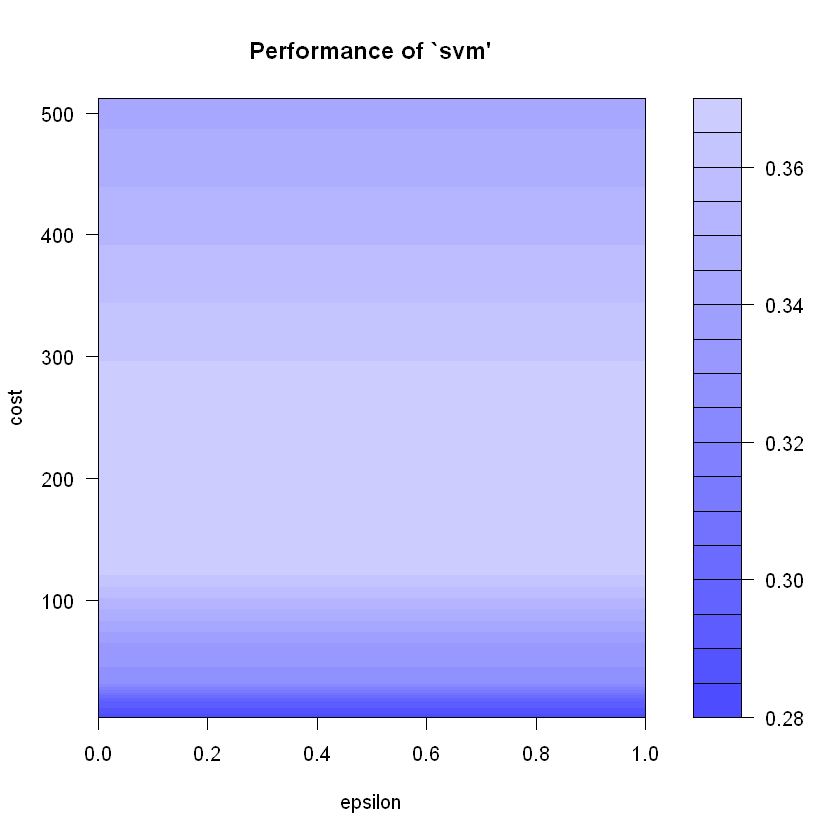

In [164]:
smv.epsilon <- tune(svm,type ~ bone_length + rotting_flesh + hair_length, data = train,
              ranges = list(epsilon = seq(0,1,0.1), cost = 2^(2:9))
)
print(smv.epsilon )

plot(smv.epsilon )

Maintenant qu'on a choisi le paramètre epsilon optimal, égal à 0, testons notre modèle sur l'échantillon de données cross_val. 

In [165]:
model.svm <- smv.epsilon$best.model
predict.svm <- predict(model.svm, cross_val)
table<-table(predict.svm, cross_val$type)
table

exactitude<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
exactitude

           
predict.svm Ghost Ghoul Goblin
     Ghost     33     0      5
     Ghoul      0    23     15
     Goblin     7     5     23

[1] 0.7117117

# Conclusion

Nous avons vu que les algorithmes SVM et forêts aléatoires permettent d'obtenir un taux d'exactitude maximum de 71,17%, taux qui dépend grandement du choix de variables utilisées dans le modèle. Pour la compétition, j'ai utilisé ces différents modèles pour classer un jeu de données dont les étiquettes m'étaient inconnues. J'ai remarqué que les forêts d'arbres décisionnels performaient moins bien que l'algorithme SVM sur ce nouveau jeu de données. Cela peut être attribuable à la tendance qu'à cet algorithme à surentraîner les données et c'est un facteur auquel je devrais faire particulièrement attention à l'avenir.

Finalement, en utilisant l'algorithme SVM sur le modèle contenant les trois variables "bone_length", "rotting_flesh" et "hair_length", j'ai obtenu un taux d'exactitude de 0.73913.